[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amackay/hons_proj/blob/main/demo_week5.ipynb)


## Setup


In [ ]:

import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.fft as fft



In [ ]:

tau = 2*torch.pi



## Functions (ground truth)


In [ ]:

# gtf = lambda x: torch.sin(tau*x) + torch.sin(3*tau*x) + torch.sin(7*tau*x) + torch.sin(15*tau*x)
gtf = lambda x: torch.sin(x) + torch.sin(tau*tau*x) + torch.sin(10*tau*x)
# gtf = lambda x: torch.pow(x-0.5, 2) + 0.5
# gtf = lambda x: torch.heaviside(x-0.5, torch.ones(1))


# more functions to try
# surge, step, perlin noise, uniform random


## Sampling


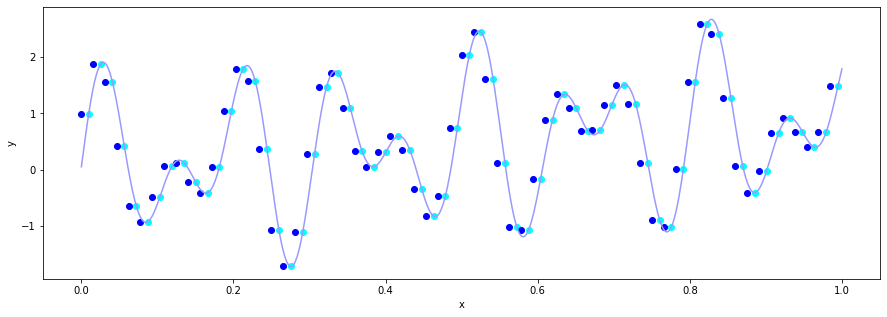

In [ ]:

N = 64  # Sample count
f = N/(1-0)  # = frequency (since domain is 0 to 1)
T = 1/f  # Sampling period

offset = 0.5 * T
offset = 0
xs = torch.arange(N) * T + offset


xs_actual = xs + torch.randn_like(xs) * 0.0 + 0.01
ys_actual = gtf(xs_actual)
ys = ys_actual + torch.randn_like(ys_actual) * 0.0




dispN = 1000  # Number of display samples
dispT = 1/dispN  # Display sampling period

disp_xs = (torch.arange(dispN) + 0.5) * dispT
disp_ys = gtf(disp_xs)


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,5)
ax.plot(disp_xs, disp_ys, c='#99f')
ax.scatter(xs_actual, ys_actual, c='#0ff')
ax.scatter(xs, ys, c='#00f')
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.show()


## Interpolation methods


### FFT


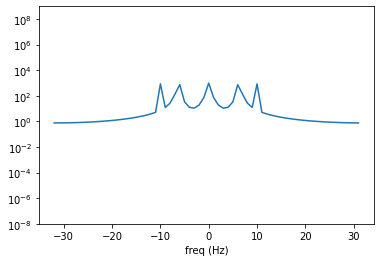

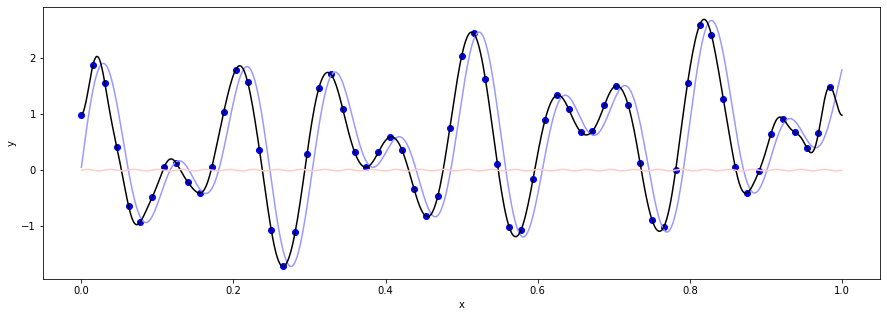

In [ ]:

zs = fft.fftshift(fft.fft(ys))

fs = torch.arange(-f/2, f/2, f/N)
plt.semilogy(fs, abs(zs)**2)
plt.xlabel('freq (Hz)')
plt.ylim(1.0e-8, 1.0e9)


fys = torch.sum(
      torch.mul(
          zs.reshape((1,-1)),
          torch.exp(
              1j*tau*disp_xs.reshape((-1,1)).mul(fs.reshape((1,-1)))
          )
      ),
      dim=1
    ) / N

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,5)
ax.plot(disp_xs, disp_ys, c='#99f')
ax.scatter(xs, ys, c='#00f')
ax.plot(disp_xs, torch.real(fys), c='#000')
ax.plot(disp_xs, torch.imag(fys), c='#fcc')
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.show()



### NN setup


In [ ]:


class VanillaNN(object):

  def __init__(self, hidden_layers, layer_width):
    self.layer_count = 2 + hidden_layers
    self.width = layer_width

    layers = []
    for i in range(self.layer_count):
      inputs = 1 if (i == 0) else self.width
      outputs = 1 if (i == self.layer_count-1) else self.width
      layers.append(nn.Linear(inputs, outputs))
      if i != self.layer_count - 1:
        layers.append(nn.ReLU())
    self.net = nn.Sequential(*layers)

    self.optimizer = optim.SGD(self.net.parameters(), lr=0.01)
    self.criterion = nn.MSELoss()
    self.epochs_complete = 0

    self.statsrate = 1000
    self.x_epochs = []
    self.y_trainloss = []
    self.y_testloss = []
    self.epoch_output_pairs = []

  def logstats(self):
    if self.epochs_complete % self.statsrate == 0:
      if len(self.x_epochs) == 0 or self.epochs_complete > self.x_epochs[-1]:
        with torch.no_grad():
          self.x_epochs.append(self.epochs_complete)
          self.y_trainloss.append(self.loss(xs, ys).item())
          self.y_testloss.append(self.loss(disp_xs, disp_ys).item())
          self.epoch_output_pairs.append((
              self.epochs_complete,
              self.net(disp_xs.unsqueeze(1)).squeeze(),
          ))
      self.update_plots()
  
  def init_plots(self):
    self.out_text = display.display("Starting training", display_id=True)
    self.fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    self.ax_func = axes[0]
    self.ax_loss = axes[1]
    self.out_plot = display.display(fig, display_id=True)

  def update_plots(self):
    self.out_text.update(f'After {self.x_epochs[-1]} epochs, train loss is {self.y_trainloss[-1]}, and test loss is {self.y_testloss[-1]}.')
    self.ax_func.clear()
    self.ax_func.plot(disp_xs, disp_ys, c='#99f')
    self.ax_func.scatter(xs, ys, c='#00f')
    count = len(self.epoch_output_pairs)
    alpha = 1.
    for pair in reversed(self.epoch_output_pairs[-5:]):
      if alpha == 1.:
        c = 'k'
      else:
        c = (0.,0.5,0.,alpha)
      alpha /= 2
      self.ax_func.plot(disp_xs, pair[1], c=c, label=f'Epoch {pair[0]}')
    self.ax_func.legend(loc='upper right')
    self.ax_func.set_xlabel("x")
    self.ax_func.set_ylabel("y")
    self.ax_loss.clear()
    self.ax_loss.plot(self.x_epochs, self.y_trainloss, c='#f0f', label='train')
    self.ax_loss.plot(self.x_epochs, self.y_testloss, c='#099', label='test')
    self.ax_loss.legend(loc='upper right')
    self.ax_loss.set_xlabel("epoch")
    self.ax_loss.set_ylabel("loss")
    self.ax_loss.set_yscale('log')

    self.out_plot.update(self.fig)

  def loss(self, x, y):
    return self.criterion(self.net(x.unsqueeze(1)), y.unsqueeze(1))

  def train(self, epoch_limit=None):
    self.init_plots()
    try:
      if epoch_limit is None:
        epoch_limit = 1000000000  # train forever
      while self.epochs_complete < epoch_limit:
        self.logstats()
        self.optimizer.zero_grad()
        train_loss = self.loss(xs, ys)
        train_loss.backward()
        self.optimizer.step()
        self.epochs_complete += 1
      self.logstats()
    except KeyboardInterrupt:
      pass
    plt.close()





### NN


In [ ]:

model = VanillaNN(hidden_layers=2, layer_width=20)


'After 726000 epochs, train loss is 0.0004885306698270142, and test loss is 0.2579392194747925.'

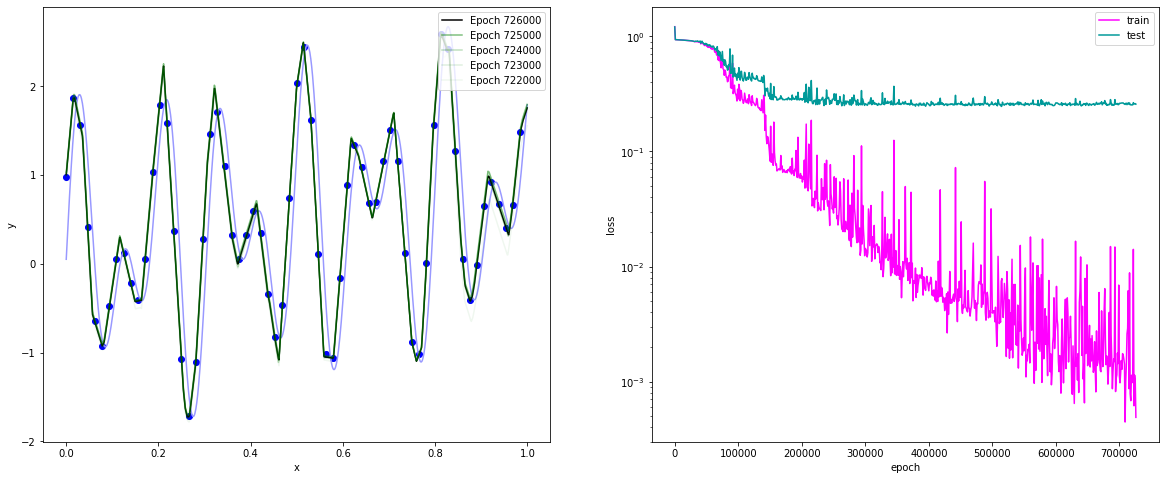

In [ ]:

# model.train(10000)
model.train()
